# Load Libraries

In [ ]:
import numpy as np 
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import os
import gsw
from seabird.cnv import fCNV
from tqdm import tqdm
import mvp_routines_old as mvp
import temporal_lag_correction as tlc
import thermal_mass_correction as tmc

# MVP CTD Import

In [32]:

Yorig = 1950
date_ref = datetime(Yorig, 1, 1)


profile_name = 'Stationary Profiling'
mvpdir       = '../MVP300_DATA/' +profile_name + '/'

list_of_mvp_files = sorted(
    filter(os.path.isfile,
           glob.glob(mvpdir + '**/*.m1', recursive=True)))

PRES_temp = []
TIME_temp = []
COND_temp = []
SALT_temp = []
TEMP_temp = []
LAT_mvp = []
LON_mvp = []
DATETIME_mvp = []
DIR = []
for mvp_dat_name in list_of_mvp_files[0:]:

    mvp_log_name=mvp_dat_name[:-3]+'.log'
    # mvp_log_name=mvpdir+'MVP_'+mvp_dat_name[-20:-3]+'.log'

    # Get start and end time of the cycle

    (mvp_tstart,mvp_tend,cycle_dur, lat, lon, dt_station) = mvp.get_log(mvp_log_name,Yorig)

    LAT_mvp.append(lat)
    LON_mvp.append(lon)
    DATETIME_mvp.append(dt_station)
    
    if cycle_dur>1:

        # Read one cycle MVP data
        (pres,cond,salt,temp) = mvp.read_mvp_cycle(mvp_dat_name)
        
        if np.nanmax(pres)-np.nanmin(pres)>2:

            # Allocate time to samples and select the ascending part 
            (pres_up,cond_up,salt_up,temp_up,time_up) = mvp.time_mvp_cycle_up(pres,cond,salt,temp,mvp_tstart,mvp_tend)
            (pres_down,cond_down,salt_down,temp_down,time_down) = mvp.time_mvp_cycle_down(pres,cond,salt,temp,mvp_tstart,mvp_tend)


            if len(pres_down)>0:
                if np.nanmax(pres_down)-np.nanmin(pres_down)>2:
                    PRES_temp.append(pres_down)
                    TIME_temp.append(time_down)
                    COND_temp.append(cond_down)
                    SALT_temp.append(salt_down)
                    TEMP_temp.append(temp_down)
                    DIR.append('down')

                    
            if len(pres_up)>0:
                if np.nanmax(pres_up)-np.nanmin(pres_up)>2:
                    PRES_temp.append(pres_up)
                    TIME_temp.append(time_up)
                    COND_temp.append(cond_up)
                    SALT_temp.append(salt_up)
                    TEMP_temp.append(temp_up)
                    DIR.append('up')

            
            

# Re-arange files into matrices
M_size = 0
for i in range(len(PRES_temp)):
    M_size = max(M_size, len(PRES_temp[i]))
    
PRES_mvp = np.zeros(( len(PRES_temp), M_size))
COND_mvp = np.zeros(( len(PRES_temp), M_size))
SALT_mvp = np.zeros(( len(PRES_temp), M_size))
TEMP_mvp = np.zeros(( len(PRES_temp), M_size))
TIME_mvp = np.zeros(( len(PRES_temp), M_size))
PRES_mvp[:] = np.nan
COND_mvp[:] = np.nan
SALT_mvp[:] = np.nan
TEMP_mvp[:] = np.nan
TIME_mvp[:] = np.nan

del M_size

for i in range(len(PRES_temp)):
    PRES_mvp[i,0:len(PRES_temp[i])] = PRES_temp[i]
    COND_mvp[i,0:len(PRES_temp[i])] = COND_temp[i]
    SALT_mvp[i,0:len(PRES_temp[i])] = SALT_temp[i]
    TEMP_mvp[i,0:len(PRES_temp[i])] = TEMP_temp[i]
    TIME_mvp[i,0:len(PRES_temp[i])] = TIME_temp[i]
del PRES_temp, TEMP_temp, TIME_temp, COND_temp, SALT_temp


# MVP Raw import

In [33]:
# Loop on MVP .m1 and log files in the directory

list_of_mvp_files = sorted(filter(os.path.isfile,\
                           glob.glob(mvpdir + '**/*.raw', recursive=True)))

print('Found ' + str(len(list_of_mvp_files)) + ' MVP files in the directory: ' + mvpdir)

PRES_temp = []
TEMP_temp = []
COND_temp = []
SOUNDVEL_temp = []
DO_temp = []
TEMP2_temp = [] # temp from DO sensor
SUNA_temp = []
FLUO_temp = [] 
TURB_temp = []
PH_temp = [] 
SALT_temp = []
TIME_mvp_temp = []
LAT_temp = []
LON_temp= []
DATETIME_mvp_raw = []
DIR = []
id = 0
for mvp_dat_name in list_of_mvp_files[0:]:

    mvp_log_name=mvp_dat_name[:-4]+'.log'

    # Get start and end time of the cycle

    (mvp_tstart,mvp_tend,cycle_dur, lat, lon, dt_station) = mvp.get_log(mvp_log_name,Yorig)

    
    if cycle_dur>1:

        # Read one cycle MVP data  
        (pres,soundvel,cond,temp,do_raw,temp2_raw,suna_raw,fluo_raw,turb_raw,ph_raw) = mvp.read_mvp_cycle_raw(mvp_dat_name)
        (pres,soundvel,cond,temp,do,temp2,suna,fluo,turb,ph) = mvp.raw_data_conversion(pres,soundvel,cond,temp,do_raw,temp2_raw,suna_raw,fluo_raw,turb_raw,ph_raw)

        freq_echant = len(pres)/cycle_dur
        DATETIME_mvp_raw.append(dt_station)
        
        if np.nanmax(pres)-np.nanmin(pres)>2:

            # Allocate time to samples and select the ascending part 
            (pres_up,soundvel_up,cond_up,temp_up,do_up,temp2_up,suna_up,fluo_up,turb_up,ph_up,time_up) = mvp.time_mvp_cycle_up_bgc(pres,soundvel,cond,temp,do,temp2,suna,fluo,turb,ph,mvp_tstart,mvp_tend)
            (pres_down,soundvel_down,cond_down,temp_down,do_down,temp2_down,suna_down,fluo_down,turb_down,ph_down,time_down) = mvp.time_mvp_cycle_down_bgc(pres,soundvel,cond,temp,do,temp2,suna,fluo,turb,ph,mvp_tstart,mvp_tend)


            if len(pres_down)>0:
                if np.nanmax(pres_down)-np.nanmin(pres_down)>2:
                    PRES_temp.append(pres_down)
                    SOUNDVEL_temp.append(soundvel_down)
                    COND_temp.append(cond_down)
                    TEMP_temp.append(temp_down)
                    DO_temp.append(do_down)
                    TEMP2_temp.append(temp2_down)
                    SUNA_temp.append(suna_down)
                    FLUO_temp.append(fluo_down)
                    TURB_temp.append(turb_down)
                    PH_temp.append(ph_down)
                    SALT_temp.append(gsw.SP_from_C(cond_down, temp_down,pres_down))
                    TIME_mvp_temp.append(time_down)
                    LAT_temp.append(lat)
                    LON_temp.append(lon)

                    DIR.append('down')

                    
            if len(pres_up)>0:
                if np.nanmax(pres_up)-np.nanmin(pres_up)>2:
                    PRES_temp.append(pres_up)
                    SOUNDVEL_temp.append(soundvel_up)
                    COND_temp.append(cond_up)
                    TEMP_temp.append(temp_up)
                    DO_temp.append(do_up)
                    TEMP2_temp.append(temp2_up)
                    SUNA_temp.append(suna_up)
                    FLUO_temp.append(fluo_up)
                    TURB_temp.append(turb_up)
                    PH_temp.append(ph_up)
                    SALT_temp.append(gsw.SP_from_C(cond_up, temp_up,pres_up))
                    TIME_mvp_temp.append(time_up)
                    LAT_temp.append(lat)
                    LON_temp.append(lon)

                    DIR.append('up')


    id+=1
            

# Re-arange files into matrices
M_size = 0
for i in range(len(PRES_temp)):
    M_size = max(M_size, len(PRES_temp[i]))
    
PRES_mvp_raw = np.zeros(( len(PRES_temp), M_size))
SOUNDVEL_mvp = np.zeros(( len(PRES_temp), M_size))
COND_mvp_raw = np.zeros(( len(PRES_temp), M_size))
TEMP_mvp_raw = np.zeros(( len(PRES_temp), M_size))
DO_mvp = np.zeros(( len(PRES_temp), M_size))
TEMP_mvp2 = np.zeros(( len(PRES_temp), M_size))
SUNA_mvp = np.zeros(( len(PRES_temp), M_size))
FLUO_mvp = np.zeros(( len(PRES_temp), M_size))
TURB_mvp = np.zeros(( len(PRES_temp), M_size))
PH_mvp = np.zeros(( len(PRES_temp), M_size))
SALT_mvp_raw = np.zeros(( len(PRES_temp), M_size))
TIME_mvp_raw = np.zeros(( len(PRES_temp), M_size))
LAT_mvp_raw = np.zeros(( len(PRES_temp), M_size))
LON_mvp_raw = np.zeros(( len(PRES_temp), M_size))
PRES_mvp_raw[:] = np.nan
SOUNDVEL_mvp[:] = np.nan
COND_mvp_raw[:] = np.nan
TEMP_mvp_raw[:] = np.nan
DO_mvp[:] = np.nan
TEMP_mvp2[:] = np.nan
SUNA_mvp[:] = np.nan
FLUO_mvp[:] = np.nan
TURB_mvp[:] = np.nan
PH_mvp[:] = np.nan
SALT_mvp_raw[:] = np.nan
TIME_mvp_raw[:] = np.nan
LAT_mvp_raw[:] = np.nan
LON_mvp_raw[:] = np.nan

del M_size

for i in range(len(PRES_temp)):
    PRES_mvp_raw[i,0:len(PRES_temp[i])] = PRES_temp[i]
    SOUNDVEL_mvp[i,0:len(SOUNDVEL_temp[i])] = SOUNDVEL_temp[i]
    COND_mvp_raw[i,0:len(COND_temp[i])] = COND_temp[i]
    TEMP_mvp_raw[i,0:len(TEMP_temp[i])] = TEMP_temp[i]
    DO_mvp[i,0:len(DO_temp[i])] = DO_temp[i]
    TEMP_mvp2[i,0:len(TEMP2_temp[i])] = TEMP2_temp[i]
    SUNA_mvp[i,0:len(SUNA_temp[i])] = SUNA_temp[i]
    FLUO_mvp[i,0:len(FLUO_temp[i])] = FLUO_temp[i]
    TURB_mvp[i,0:len(TURB_temp[i])] = TURB_temp[i]
    PH_mvp[i,0:len(PH_temp[i])] = PH_temp[i]
    SALT_mvp_raw[i,0:len(SALT_temp[i])] = SALT_temp[i]
    TIME_mvp_raw[i,0:len(TIME_mvp_temp[i])] = TIME_mvp_temp[i]
    LAT_mvp_raw[i,0:len(PRES_temp[i])] = LAT_temp[i]*len(PRES_temp[i])
    LON_mvp_raw[i,0:len(PRES_temp[i])] = LON_temp[i]*len(PRES_temp[i])
del PRES_temp, SOUNDVEL_temp, DO_temp, TEMP2_temp, SUNA_temp, FLUO_temp, TURB_temp, PH_temp, COND_temp, TEMP_temp, SALT_temp, TIME_mvp_temp, LAT_temp, LON_temp

Found 6 MVP files in the directory: ../MVP300_DATA/Stationary Profiling/


In [34]:
print("\nMVP raw :")
for idx, (lat, lon, dt) in enumerate(zip(LAT_mvp_raw[0], LON_mvp_raw[0], DATETIME_mvp_raw)):
    print(f"  Profil {idx+1} - Latitude: {lat:.5f}, Longitude: {lon:.5f}, Date/Heure: {dt}")


MVP raw :
  Profil 1 - Latitude: 956782.92404, Longitude: 139241.03750, Date/Heure: 2025-08-09 10:28:58.600000
  Profil 2 - Latitude: 956782.92404, Longitude: 139241.03750, Date/Heure: 2025-08-11 09:54:09
  Profil 3 - Latitude: 956782.92404, Longitude: 139241.03750, Date/Heure: 2025-08-11 07:00:47.600000
  Profil 4 - Latitude: 956782.92404, Longitude: 139241.03750, Date/Heure: 2025-08-11 07:10:43.600000
  Profil 5 - Latitude: 956782.92404, Longitude: 139241.03750, Date/Heure: 2025-08-11 03:32:04.200000
  Profil 6 - Latitude: 956782.92404, Longitude: 139241.03750, Date/Heure: 2025-08-11 00:01:16.800000


# Bathy CTD import

In [35]:
ctddir       = '../BATHYSONDE/DATA/TRAIT/CNV/'


list_of_ctd_files = sorted(filter(os.path.isfile,\
                           glob.glob(ctddir + '*.cnv')))

print('Found ' + str(len(list_of_ctd_files)) + ' CTD files in the directory: ' + ctddir)

# keys: ['scan', 'timeJ', 'timeQ', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP', 'CNDC', 'descentrate', 'flECO-AFL', 'v1', 'wetCDOM', 'v0', 'turbWETntu0', 'v5', 'CStarTr0', 'CStarAt0', 'oxygen_ml_L', 'oxsolML/L', 'v2', 'flag', 'timeS']
LAT_ctd_temp = []
LON_ctd_temp = []
PRES_ctd_temp = []
TEMP_ctd_temp = []
COND_ctd_temp = []
TURB_ctd_temp = []
OXY_ctd_temp = []
FLUO_ctd_temp = []
CDOM_ctd_temp = []
DATETIME_ctd = []
SALT_ctd_temp = []

for ctd_dat_name in tqdm(list_of_ctd_files[0:]):
    ctd_files = ctd_dat_name
    cnv = fCNV(ctd_files)
    LAT_ctd_temp.append(cnv['LATITUDE'])
    LON_ctd_temp.append(cnv['LONGITUDE'])
    PRES_ctd_temp.append(cnv['PRES'])
    TEMP_ctd_temp.append(cnv['TEMP'])
    COND_ctd_temp.append(cnv['CNDC']*10)
    SALT_ctd_temp.append(gsw.SP_from_C(cnv['CNDC']*10, cnv['TEMP'], cnv['PRES']))
    TURB_ctd_temp.append(cnv['turbWETntu0'])
    OXY_ctd_temp.append(cnv['oxygen_ml_L'])
    FLUO_ctd_temp.append(cnv['flECO-AFL'])
    CDOM_ctd_temp.append(cnv['wetCDOM'])

    with open(ctd_dat_name, 'r') as f:
        header_lines = []
        for _ in range(10): 
            header_lines.append(f.readline().strip())

    line = header_lines[9]
    date_str = line.split('=')[1].strip()
    dt = datetime.strptime(date_str, "%b %d %Y %H:%M:%S")
    DATETIME_ctd.append(dt)

# Re-arange files into matrices
M_size = 0
for i in range(len(PRES_ctd_temp)):
    M_size = max(M_size, len(PRES_ctd_temp[i]))
    
PRES_ctd = np.zeros(( len(PRES_ctd_temp), M_size))
COND_ctd = np.zeros(( len(PRES_ctd_temp), M_size))
SALT_ctd = np.zeros(( len(PRES_ctd_temp), M_size))
TEMP_ctd = np.zeros(( len(PRES_ctd_temp), M_size))
TURB_ctd = np.zeros(( len(PRES_ctd_temp), M_size))
OXY_ctd = np.zeros(( len(PRES_ctd_temp), M_size))
FLUO_ctd = np.zeros(( len(PRES_ctd_temp), M_size))
CDOM_ctd = np.zeros(( len(PRES_ctd_temp), M_size))
LAT_ctd = np.zeros(( len(PRES_ctd_temp), M_size))
LON_ctd = np.zeros(( len(PRES_ctd_temp), M_size))
PRES_ctd[:] = np.nan
COND_ctd[:] = np.nan
SALT_ctd[:] = np.nan    
TEMP_ctd[:] = np.nan
TURB_ctd[:] = np.nan
OXY_ctd[:] = np.nan
FLUO_ctd[:] = np.nan
CDOM_ctd[:] = np.nan
LAT_ctd[:] = np.nan
LON_ctd[:] = np.nan
del M_size
for i in range(len(PRES_ctd_temp)):
    LAT_ctd[i,0:len(PRES_ctd_temp[i])] = LAT_ctd_temp[i]
    LON_ctd[i,0:len(PRES_ctd_temp[i])] = LON_ctd_temp[i]
    PRES_ctd[i,0:len(PRES_ctd_temp[i])] = PRES_ctd_temp[i]
    TEMP_ctd[i,0:len(PRES_ctd_temp[i])] = TEMP_ctd_temp[i]
    COND_ctd[i,0:len(PRES_ctd_temp[i])] = COND_ctd_temp[i]
    SALT_ctd[i,0:len(PRES_ctd_temp[i])] = SALT_ctd_temp[i]
    TURB_ctd[i,0:len(PRES_ctd_temp[i])] = TURB_ctd_temp[i]
    OXY_ctd[i,0:len(PRES_ctd_temp[i])] = OXY_ctd_temp[i]
    FLUO_ctd[i,0:len(PRES_ctd_temp[i])] = FLUO_ctd_temp[i]
    CDOM_ctd[i,0:len(PRES_ctd_temp[i])] = CDOM_ctd_temp[i]
del PRES_ctd_temp, TEMP_ctd_temp, COND_ctd_temp, SALT_ctd_temp, TURB_ctd_temp, OXY_ctd_temp, FLUO_ctd_temp, CDOM_ctd_temp, LAT_ctd_temp, LON_ctd_temp



Found 4 CTD files in the directory: ../BATHYSONDE/DATA/TRAIT/CNV/


100%|██████████| 4/4 [00:46<00:00, 11.70s/it]


# Comparison

In [36]:

print("CTD :")
for idx, (lat, lon, dt) in enumerate(zip(LAT_ctd, LON_ctd, DATETIME_ctd)):
    print(f"  Profil {idx+1} - Latitude: {lat[0]:.5f}, Longitude: {lon[0]:.5f}, Date/Heure: {dt}")

print("\nMVP :")
for idx, (lat, lon, dt) in enumerate(zip(LAT_mvp, LON_mvp, DATETIME_mvp)):
    print(f"  Profil {idx+1} - Latitude: {lat:.5f}, Longitude: {lon:.5f}, Date/Heure: {dt}")

print("\nMVP raw :")
for idx, (lat, lon, dt) in enumerate(zip(LAT_mvp_raw[0], LON_mvp_raw[0], DATETIME_mvp_raw)):
    print(f"  Profil {idx+1} - Latitude: {lat:.5f}, Longitude: {lon:.5f}, Date/Heure: {dt}")

CTD :
  Profil 1 - Latitude: 42.91344, Longitude: 6.22296, Date/Heure: 2025-08-09 08:27:35
  Profil 2 - Latitude: 42.31256, Longitude: 6.08764, Date/Heure: 2025-08-10 22:40:15
  Profil 3 - Latitude: 42.48202, Longitude: 6.12174, Date/Heure: 2025-08-11 02:04:24
  Profil 4 - Latitude: 42.70430, Longitude: 6.15568, Date/Heure: 2025-08-11 05:49:06

MVP :
  Profil 1 - Latitude: 42.89352, Longitude: 6.24231, Date/Heure: 2025-08-09 10:28:58.600000
  Profil 2 - Latitude: 42.78807, Longitude: 6.17795, Date/Heure: 2025-08-11 09:54:09
  Profil 3 - Latitude: 42.70605, Longitude: 6.14948, Date/Heure: 2025-08-11 07:00:47.600000
  Profil 4 - Latitude: 42.70608, Longitude: 6.14825, Date/Heure: 2025-08-11 07:10:43.600000
  Profil 5 - Latitude: 42.47797, Longitude: 6.12631, Date/Heure: 2025-08-11 03:32:04.200000
  Profil 6 - Latitude: 42.30967, Longitude: 6.09565, Date/Heure: 2025-08-11 00:01:16.800000

MVP raw :
  Profil 1 - Latitude: 956782.92404, Longitude: 139241.03750, Date/Heure: 2025-08-09 10:28:

Correspondance id profil ESSTECH25:
CTD mat MVP mat     CTD id     MVP id          commentaire
0       0               S001       bathy 0
1       5               S002       bathy 7
2       4               S003       bathy 6
3       2-3             S004       bathy 4     deux fichiers MVP pourquoi ?
        1               S005       bathy 3     ctd pas traité 
                        S006       bathy 1     ctd pas traité  + manque fichier M1 dans mvp



# Plot profiles

Text(0, 0.5, 'Pressure, dbar')

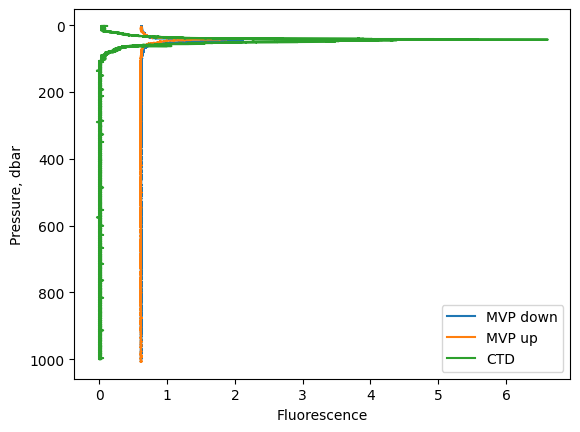

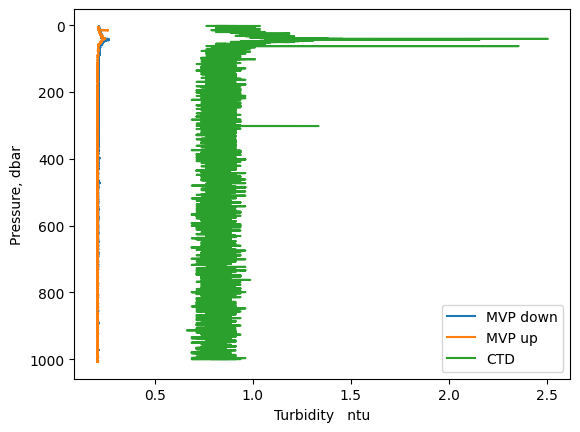

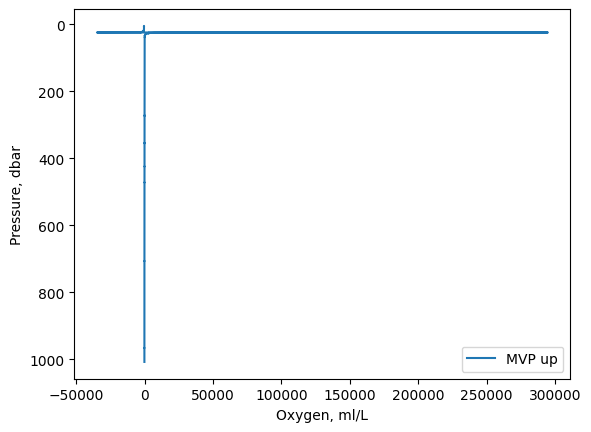

In [37]:
i = 10
j = 1

plt.figure(1)
plt.plot(FLUO_mvp[i],PRES_mvp_raw[i],label='MVP down')
plt.plot(FLUO_mvp[i+1],PRES_mvp_raw[i+1],label='MVP up')
plt.plot(FLUO_ctd[j],PRES_ctd[j],label='CTD')
plt.legend()    
plt.gca().invert_yaxis()
plt.xlabel('Fluorescence')    
plt.ylabel('Pressure, dbar')

plt.figure(2)
plt.plot(TURB_mvp[i],PRES_mvp_raw[i],label='MVP down')
plt.plot(TURB_mvp[i+1],PRES_mvp_raw[i+1],label='MVP up')
plt.plot(TURB_ctd[j],PRES_ctd[j],label='CTD')
plt.legend()    
plt.gca().invert_yaxis()
plt.xlabel('Turbidity   ntu')    
plt.ylabel('Pressure, dbar')

plt.figure(3)
# plt.plot(DO_mvp[i],PRES_mvp_raw[i],label='MVP down')
plt.plot(DO_mvp[i+1],PRES_mvp_raw[i+1],label='MVP up')
# plt.plot(OXY_ctd[j],PRES_ctd[j],label='CTD')
plt.legend()    
plt.gca().invert_yaxis()
plt.xlabel('Oxygen, ml/L')    
plt.ylabel('Pressure, dbar')


Text(0, 0.5, 'Pressure, dbar')

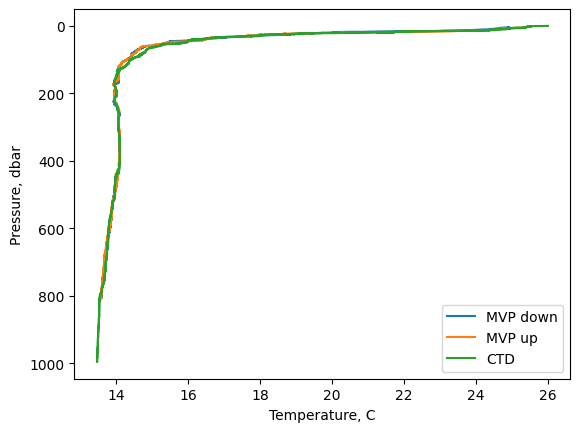

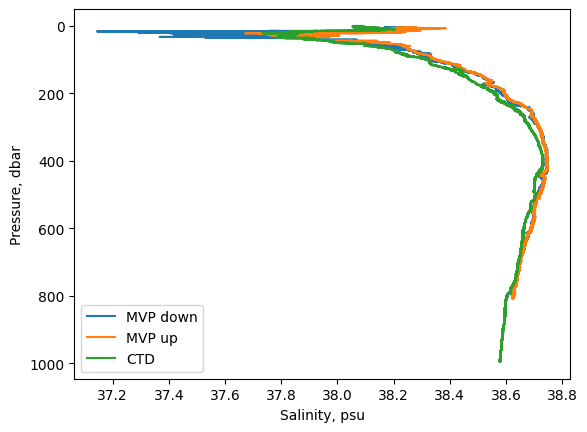

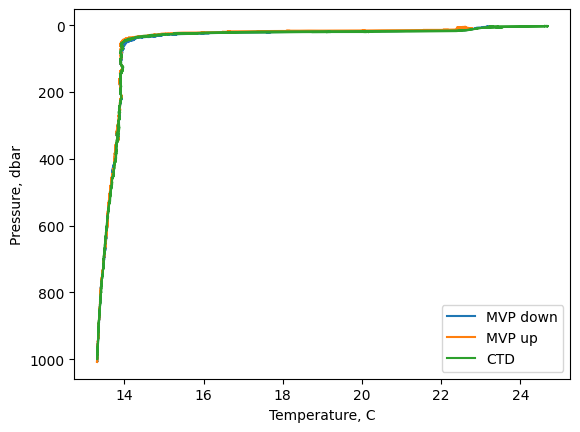

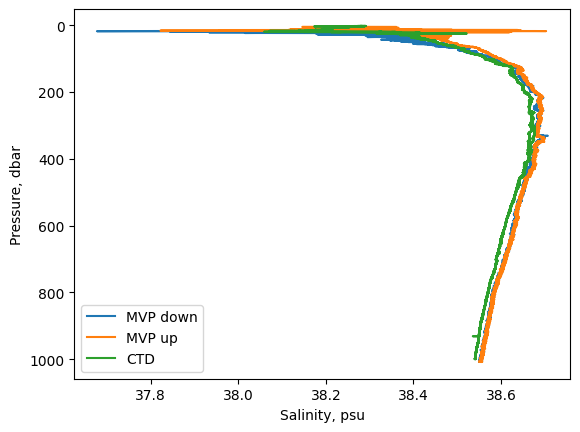

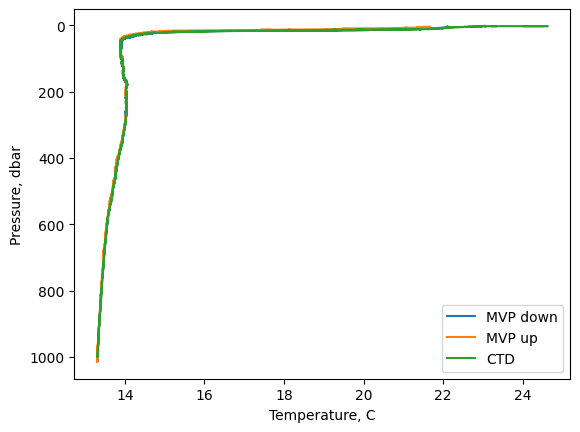

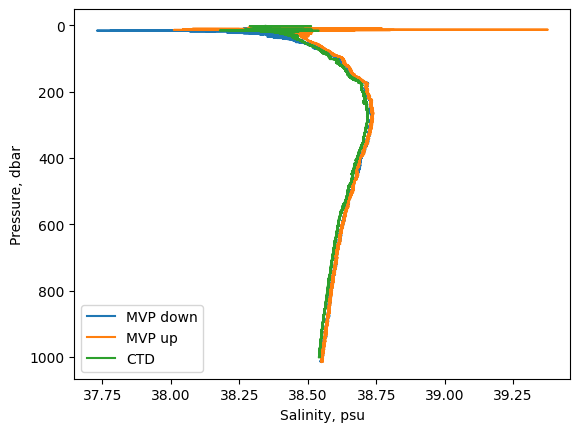

In [38]:
i = 0
j = 0

plt.figure(1)
plt.plot(TEMP_mvp[i],PRES_mvp[i],label='MVP down')
plt.plot(TEMP_mvp[i+1],PRES_mvp[i+1],label='MVP up')
plt.plot(TEMP_ctd[j],PRES_ctd[j],label='CTD')
plt.legend()    
plt.gca().invert_yaxis()
plt.xlabel('Temperature, C')    
plt.ylabel('Pressure, dbar')


plt.figure(2)
plt.plot(SALT_mvp[i],PRES_mvp[i],label='MVP down')
plt.plot(SALT_mvp[i+1],PRES_mvp[i+1],label='MVP up')
plt.plot(SALT_ctd[j],PRES_ctd[j],label='CTD')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Salinity, psu')
plt.ylabel('Pressure, dbar')



i = 10
j = 1

plt.figure(3)
plt.plot(TEMP_mvp[i],PRES_mvp[i],label='MVP down')
plt.plot(TEMP_mvp[i+1],PRES_mvp[i+1],label='MVP up')
plt.plot(TEMP_ctd[j],PRES_ctd[j],label='CTD')
plt.legend()    
plt.gca().invert_yaxis()
plt.xlabel('Temperature, C')    
plt.ylabel('Pressure, dbar')


plt.figure(4)
plt.plot(SALT_mvp[i],PRES_mvp[i],label='MVP down')
plt.plot(SALT_mvp[i+1],PRES_mvp[i+1],label='MVP up')
plt.plot(SALT_ctd[j],PRES_ctd[j],label='CTD')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Salinity, psu')
plt.ylabel('Pressure, dbar')


i = 8
j = 2

plt.figure(5)
plt.plot(TEMP_mvp[i],PRES_mvp[i],label='MVP down')
plt.plot(TEMP_mvp[i+1],PRES_mvp[i+1],label='MVP up')
plt.plot(TEMP_ctd[j],PRES_ctd[j],label='CTD')
plt.legend()    
plt.gca().invert_yaxis()
plt.xlabel('Temperature, C')    
plt.ylabel('Pressure, dbar')


plt.figure(6)
plt.plot(SALT_mvp[i],PRES_mvp[i],label='MVP down')
plt.plot(SALT_mvp[i+1],PRES_mvp[i+1],label='MVP up')
plt.plot(SALT_ctd[j],PRES_ctd[j],label='CTD')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Salinity, psu')
plt.ylabel('Pressure, dbar')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Temperature, C')

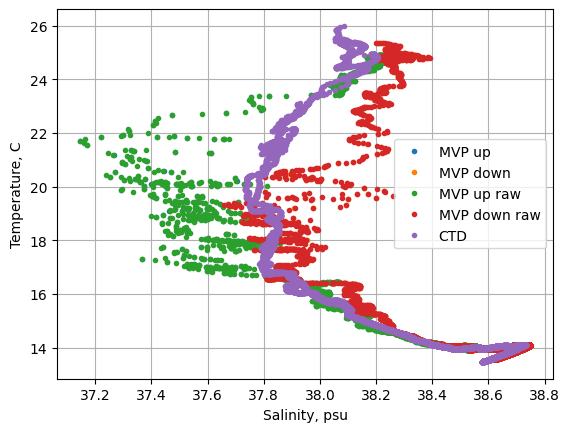

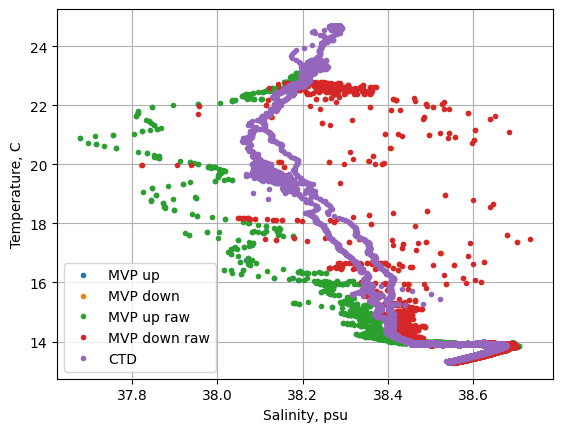

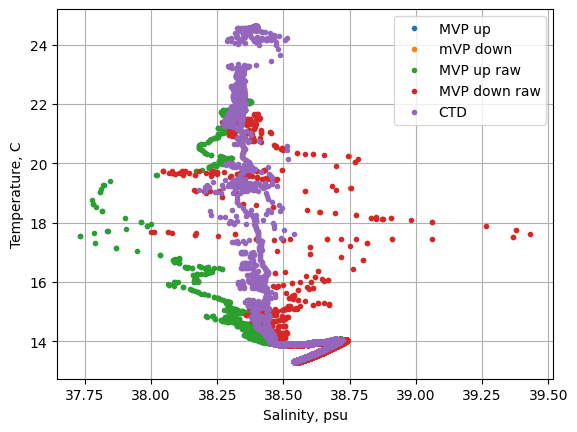

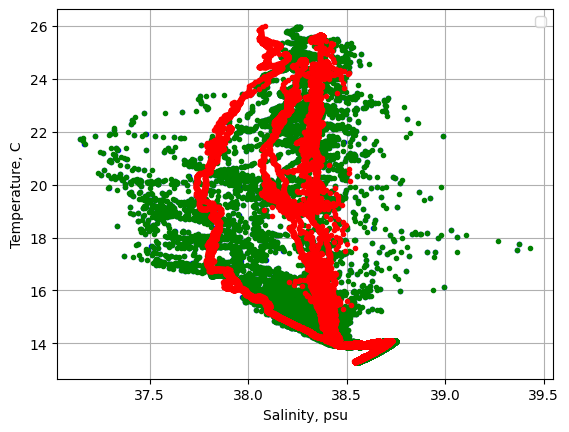

In [39]:
i = 0
j=0

plt.figure(1)
plt.plot(SALT_mvp[i],TEMP_mvp[i],label='MVP up',linestyle='', marker='.')
plt.plot(SALT_mvp[i+1],TEMP_mvp[i+1],label='MVP down',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i],TEMP_mvp_raw[i],label='MVP up raw',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i+1],TEMP_mvp_raw[i+1],label='MVP down raw',linestyle='', marker='.')
plt.plot(SALT_ctd[j],TEMP_ctd[j],label='CTD', linestyle='', marker='.')
plt.legend()  
plt.grid() 
plt.xlabel('Salinity, psu') 
plt.ylabel('Temperature, C')

i = 10
j= 1

plt.figure(2)
plt.plot(SALT_mvp[i],TEMP_mvp[i],label='MVP up',linestyle='', marker='.')
plt.plot(SALT_mvp[i+1],TEMP_mvp[i+1],label='MVP down',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i],TEMP_mvp_raw[i],label='MVP up raw',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i+1],TEMP_mvp_raw[i+1],label='MVP down raw',linestyle='', marker='.')
plt.plot(SALT_ctd[j],TEMP_ctd[j],label='CTD', linestyle='', marker='.')
plt.legend()  
plt.grid() 
plt.xlabel('Salinity, psu') 
plt.ylabel('Temperature, C')

i = 8
j= 2

plt.figure(3)
plt.plot(SALT_mvp[i],TEMP_mvp[i],label='MVP up',linestyle='', marker='.')
plt.plot(SALT_mvp[i+1],TEMP_mvp[i+1],label='mVP down',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i],TEMP_mvp_raw[i],label='MVP up raw',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i+1],TEMP_mvp_raw[i+1],label='MVP down raw',linestyle='', marker='.')
plt.plot(SALT_ctd[j],TEMP_ctd[j],label='CTD', linestyle='', marker='.')
plt.legend()  
plt.grid() 
plt.xlabel('Salinity, psu') 
plt.ylabel('Temperature, C')


plt.figure(4)
for i in range(0,len(PRES_mvp),2):
    plt.plot(SALT_mvp[i],TEMP_mvp[i],linestyle='', marker='.',color='blue')
    plt.plot(SALT_mvp[i+1],TEMP_mvp[i+1],linestyle='', marker='.',color='blue')
for i in range(0,len(PRES_mvp_raw),2):
    plt.plot(SALT_mvp_raw[i],TEMP_mvp_raw[i],linestyle='', marker='.',color='green')
    plt.plot(SALT_mvp_raw[i+1],TEMP_mvp_raw[i+1],linestyle='', marker='.',color='green')
for j in range(0,len(PRES_ctd),1):
    plt.plot(SALT_ctd[j],TEMP_ctd[j], linestyle='', marker='.',color='red')
plt.legend()   
plt.grid()
plt.xlabel('Salinity, psu') 
plt.ylabel('Temperature, C')





# Compar CTD with MVP raw

In [40]:
# Interpolate MVP and CTD data on a regular pressure grid
print(np.nanmin(PRES_mvp))
pmin = np.nanmin(PRES_mvp)
pmax = np.nanmax(PRES_mvp)
n_points = 2000  # number of pressure levels

pressure_grid = np.linspace(pmin, pmax, n_points)
print(pressure_grid.shape)
TEMP_mvp_interp_temp = mvp.vertical_interp(PRES_mvp, TEMP_mvp, pressure_grid)
SALT_mvp_interp_temp = mvp.vertical_interp(PRES_mvp, SALT_mvp, pressure_grid)
TIME_mvp_interp_temp = mvp.vertical_interp(PRES_mvp, TIME_mvp, pressure_grid)

TEMP_ctd_interp_temp = mvp.vertical_interp(PRES_ctd, TEMP_ctd, pressure_grid)
SALT_ctd_interp_temp = mvp.vertical_interp(PRES_ctd, SALT_ctd, pressure_grid)

3.44
(2000,)


In [41]:
# Select only the 3 profiles matching with ctd for comparison
TEMP_mvp_interp_down = np.zeros((3, TEMP_mvp_interp_temp.shape[1]))
SALT_mvp_interp_down = np.zeros((3, SALT_mvp_interp_temp.shape[1]))
TIME_mvp_interp_down = np.zeros((3, TIME_mvp_interp_temp.shape[1]))

TEMP_mvp_interp_down[0,:] = TEMP_mvp_interp_temp[0,:]
TEMP_mvp_interp_down[1,:] = TEMP_mvp_interp_temp[10,:]
TEMP_mvp_interp_down[2,:] = TEMP_mvp_interp_temp[8,:]

SALT_mvp_interp_down[0,:] = SALT_mvp_interp_temp[0,:]
SALT_mvp_interp_down[1,:] = SALT_mvp_interp_temp[10,:]
SALT_mvp_interp_down[2,:] = SALT_mvp_interp_temp[8,:] 

TIME_mvp_interp_down[0,:] = TIME_mvp_interp_temp[0,:]
TIME_mvp_interp_down[1,:] = TIME_mvp_interp_temp[10,:]   
TIME_mvp_interp_down[2,:] = TIME_mvp_interp_temp[8,:]

TEMP_mvp_interp_up = np.zeros((3, TEMP_mvp_interp_temp.shape[1]))
SALT_mvp_interp_up = np.zeros((3, SALT_mvp_interp_temp.shape[1]))
TIME_mvp_interp_up = np.zeros((3, TIME_mvp_interp_temp.shape[1]))       

TEMP_mvp_interp_up[0,:] = TEMP_mvp_interp_temp[1,:]
TEMP_mvp_interp_up[1,:] = TEMP_mvp_interp_temp[11,:]
TEMP_mvp_interp_up[2,:] = TEMP_mvp_interp_temp[9,:]

SALT_mvp_interp_up[0,:] = SALT_mvp_interp_temp[1,:]
SALT_mvp_interp_up[1,:] = SALT_mvp_interp_temp[11,:]
SALT_mvp_interp_up[2,:] = SALT_mvp_interp_temp[9,:]

TIME_mvp_interp_up[0,:] = TIME_mvp_interp_temp[1,:]
TIME_mvp_interp_up[1,:] = TIME_mvp_interp_temp[11,:]    
TIME_mvp_interp_up[2,:] = TIME_mvp_interp_temp[9,:]


TEMP_ctd_interp = TEMP_ctd_interp_temp[:3,:]
SALT_ctd_interp = SALT_ctd_interp_temp[:3,:]

del TEMP_mvp_interp_temp, SALT_mvp_interp_temp, TEMP_ctd_interp_temp, SALT_ctd_interp_temp, TIME_mvp_interp_temp


Différences Température (MVP - CTD) sur 3 profils :
  Moyenne : -0.011 °C
  Médiane : -0.004 °C
  Écart-type : 0.090 °C
  Min : -1.502 °C
  Max : 1.523 °C

Différences Salinité (MVP - CTD) sur 3 profils :
  Moyenne : 0.012 psu
  Médiane : 0.015 psu
  Écart-type : 0.038 psu
  Min : -0.569 psu
  Max : 0.152 psu



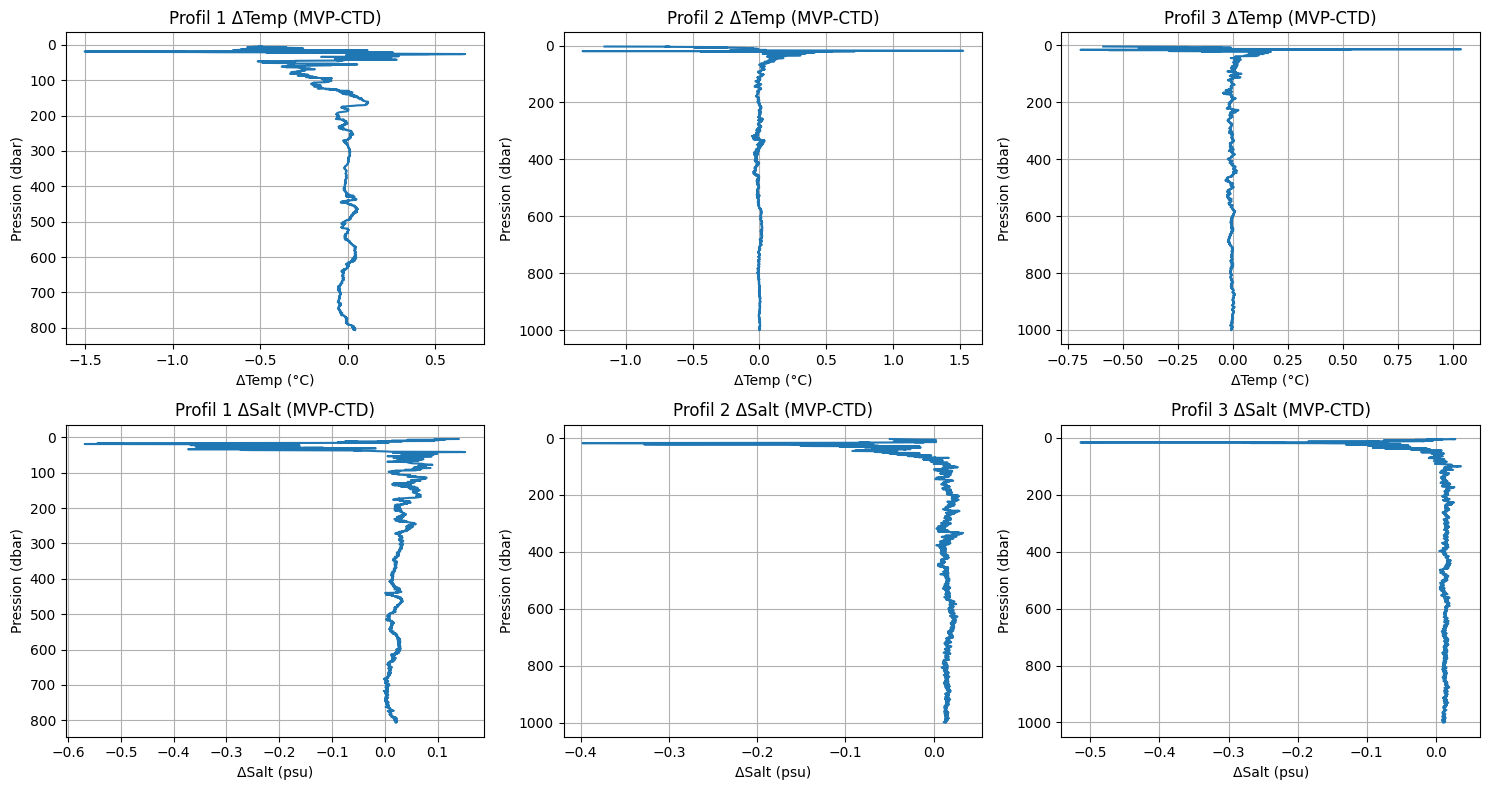

In [42]:
# differences study between MVP down and CTD profiles

# Calcul des différences entre les profils interpolés (MVP - CTD)
diff_temp_down = TEMP_mvp_interp_down - TEMP_ctd_interp
diff_salt_down = SALT_mvp_interp_down - SALT_ctd_interp

# Masquer les NaN pour les statistiques
mask_temp = ~np.isnan(diff_temp_down)
mask_salt = ~np.isnan(diff_salt_down)

# Statistiques température
print("Différences Température (MVP - CTD) sur 3 profils :")
print(f"  Moyenne : {np.nanmean(diff_temp_down):.3f} °C")
print(f"  Médiane : {np.nanmedian(diff_temp_down):.3f} °C")
print(f"  Écart-type : {np.nanstd(diff_temp_down):.3f} °C")
print(f"  Min : {np.nanmin(diff_temp_down):.3f} °C")
print(f"  Max : {np.nanmax(diff_temp_down):.3f} °C\n")

# Statistiques salinité
print("Différences Salinité (MVP - CTD) sur 3 profils :")
print(f"  Moyenne : {np.nanmean(diff_salt_down):.3f} psu")
print(f"  Médiane : {np.nanmedian(diff_salt_down):.3f} psu")
print(f"  Écart-type : {np.nanstd(diff_salt_down):.3f} psu")
print(f"  Min : {np.nanmin(diff_salt_down):.3f} psu")
print(f"  Max : {np.nanmax(diff_salt_down):.3f} psu\n")

# Plots des différences pour chaque profil
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=False)
for k in range(3):
    axs[0, k].plot(diff_temp_down[k], pressure_grid)
    axs[0, k].set_title(f'Profil {k+1} ΔTemp (MVP-CTD)')
    axs[0, k].invert_yaxis()
    axs[0, k].set_xlabel('ΔTemp (°C)')
    axs[0, k].set_ylabel('Pression (dbar)')
    axs[0, k].grid()

    axs[1, k].plot(diff_salt_down[k], pressure_grid)
    axs[1, k].set_title(f'Profil {k+1} ΔSalt (MVP-CTD)')
    axs[1, k].invert_yaxis()
    axs[1, k].set_xlabel('ΔSalt (psu)')
    axs[1, k].set_ylabel('Pression (dbar)')
    axs[1, k].grid()

plt.tight_layout()
plt.show()

Différences Température (MVP - CTD) sur 3 profils :
  Moyenne : -0.035 °C
  Médiane : -0.010 °C
  Écart-type : 0.208 °C
  Min : -4.278 °C
  Max : 1.282 °C

Différences Salinité (MVP - CTD) sur 3 profils :
  Moyenne : 0.023 psu
  Médiane : 0.017 psu
  Écart-type : 0.027 psu
  Min : -0.170 psu
  Max : 0.633 psu



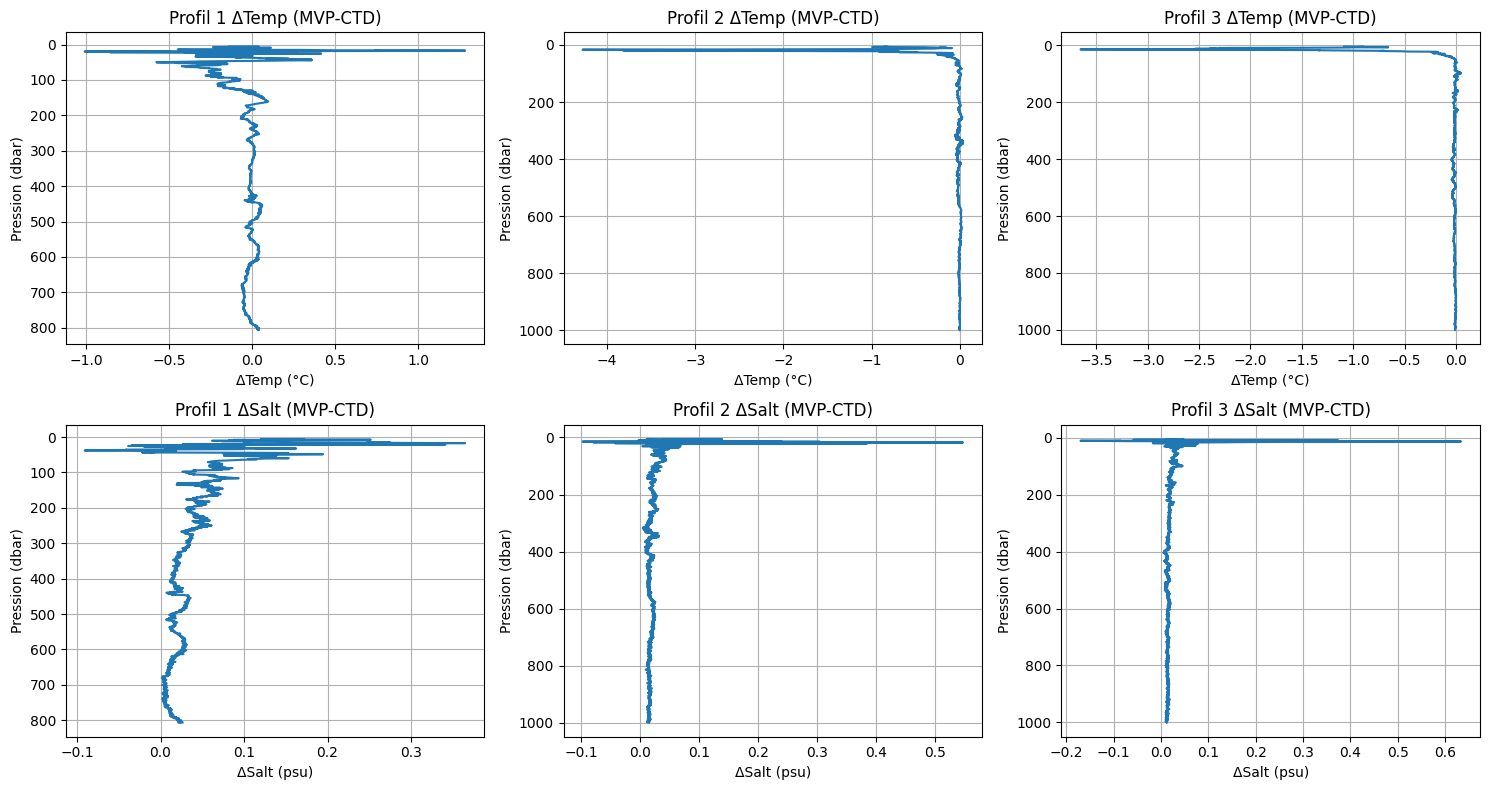

In [43]:
# differences study between MVP up and CTD profiles

# Calcul des différences entre les profils interpolés (MVP - CTD)
diff_temp_up = TEMP_mvp_interp_up - TEMP_ctd_interp
diff_salt_up = SALT_mvp_interp_up - SALT_ctd_interp

# Masquer les NaN pour les statistiques
mask_temp = ~np.isnan(diff_temp_up)
mask_salt = ~np.isnan(diff_salt_up)

# Statistiques température
print("Différences Température (MVP - CTD) sur 3 profils :")
print(f"  Moyenne : {np.nanmean(diff_temp_up):.3f} °C")
print(f"  Médiane : {np.nanmedian(diff_temp_up):.3f} °C")
print(f"  Écart-type : {np.nanstd(diff_temp_up):.3f} °C")
print(f"  Min : {np.nanmin(diff_temp_up):.3f} °C")
print(f"  Max : {np.nanmax(diff_temp_up):.3f} °C\n")

# Statistiques salinité
print("Différences Salinité (MVP - CTD) sur 3 profils :")
print(f"  Moyenne : {np.nanmean(diff_salt_up):.3f} psu")
print(f"  Médiane : {np.nanmedian(diff_salt_up):.3f} psu")
print(f"  Écart-type : {np.nanstd(diff_salt_up):.3f} psu")
print(f"  Min : {np.nanmin(diff_salt_up):.3f} psu")
print(f"  Max : {np.nanmax(diff_salt_up):.3f} psu\n")

# Plots des différences pour chaque profil
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=False)
for k in range(3):
    axs[0, k].plot(diff_temp_up[k], pressure_grid)
    axs[0, k].set_title(f'Profil {k+1} ΔTemp (MVP-CTD)')
    axs[0, k].invert_yaxis()
    axs[0, k].set_xlabel('ΔTemp (°C)')
    axs[0, k].set_ylabel('Pression (dbar)')
    axs[0, k].grid()

    axs[1, k].plot(diff_salt_up[k], pressure_grid)
    axs[1, k].set_title(f'Profil {k+1} ΔSalt (MVP-CTD)')
    axs[1, k].invert_yaxis()
    axs[1, k].set_xlabel('ΔSalt (psu)')
    axs[1, k].set_ylabel('Pression (dbar)')
    axs[1, k].grid()

plt.tight_layout()
plt.show()

# Bring corrections to MVP profiles

Viscous heating correction

In [44]:
TEMP_mvp_filt = mvp.viscous_heating(TEMP_mvp_raw, SALT_mvp_raw,PRES_mvp_raw,LON_mvp_raw, LAT_mvp_raw, TIME_mvp_raw)

Filtering of surface waves

In [45]:
SAMP_TIME = np.zeros((TIME_mvp_raw.shape[0],TIME_mvp_raw.shape[1]))
SAMP_TIME[:] = np.nan

for i in range(TIME_mvp_raw.shape[0]):
    SAMP_TIME[i,:] = (TIME_mvp_raw[i,:]-np.nanmin(TIME_mvp_raw[i,:]))*24*3600
Time = np.arange(0,np.nanmax(SAMP_TIME), 1/freq_echant)



STime_T_interp = mvp.median(SAMP_TIME, SAMP_TIME, Time)
Time_T_interp = mvp.median(SAMP_TIME, TIME_mvp_raw, Time)
Pr_T_interp = mvp.median(SAMP_TIME, PRES_mvp_raw, Time)
T_T_interp = mvp.median(SAMP_TIME, TEMP_mvp_filt, Time)
C_T_interp = mvp.median(SAMP_TIME, COND_mvp_raw, Time)
Lon_T_interp = mvp.median(SAMP_TIME, LON_mvp_raw, Time)
Lat_T_interp = mvp.median(SAMP_TIME, LAT_mvp_raw, Time)

sampling_frequency = int(freq_echant)
cutoff_frequency = 1
TEMP_filt = mvp.remove_surface_waves(T_T_interp,Time_T_interp*24*3600,sampling_frequency,cutoff_frequency,1)
COND_filt = mvp.remove_surface_waves(C_T_interp,Time_T_interp*24*3600,sampling_frequency,cutoff_frequency,1)
cutoff_frequency = 1/2
PRES_filt = mvp.remove_surface_waves(Pr_T_interp,Time_T_interp*24*3600,sampling_frequency,cutoff_frequency,1)
LAT_filt = mvp.remove_surface_waves(Lat_T_interp,Time_T_interp*24*3600,sampling_frequency,cutoff_frequency,1)
LON_filt = mvp.remove_surface_waves(Lon_T_interp,Time_T_interp*24*3600,sampling_frequency,cutoff_frequency,1)

TIME0 = mvp.vertical_interp(STime_T_interp, Time_T_interp, Time)
PRES0 = mvp.vertical_interp(STime_T_interp, PRES_filt, Time)
TEMP0 = mvp.vertical_interp(STime_T_interp, TEMP_filt, Time)
COND0 = mvp.vertical_interp(STime_T_interp, COND_filt, Time)
LON0 = mvp.vertical_interp(STime_T_interp, LON_filt, Time)
LAT0 = mvp.vertical_interp(STime_T_interp, LAT_filt, Time)

Temporal lag correction

In [46]:
# Compute distance between profiles
R = 6373.0

lat1 = np.radians(0)
lon1 = np.radians(0)
lat2 = np.radians(LAT_mvp_raw)
lon2 = np.radians(LON_mvp_raw)

dlon = lon2 - lon1
dlat = lat2 - lat1

a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

Dist = R * c * 1e3

D = np.zeros((Dist.shape[0], Dist.shape[1]))
for i in range(Dist.shape[0]):
    D_diff = np.zeros(Dist.shape[1])
    D_diff[1::] = np.abs(np.diff(Dist[i,:]))
    D[i,:] = np.cumsum(D_diff)
del D_diff, R, c, a, dlat, dlon, lon1, lat1, lon2, lat2
for i in range(D.shape[0]-1):
    D[i+1,:] = D[i+1,:]+np.nanmax(D[i,:])

D0 = D

In [ ]:
SAMP_TIME0 = np.zeros((TIME0.shape[0],TIME0.shape[1]))
SAMP_TIME0[:] = np.nan
for i in range(TIME0.shape[0]):
    SAMP_TIME0[i,:] = (TIME0[i,:]-np.nanmin(TIME0[i,:]))*24*3600

Time = np.arange(0,np.nanmax(SAMP_TIME0), 1/freq_echant)


Pr_T_interp = mvp.median(SAMP_TIME0, PRES0, Time)
T0_T_interp = mvp.median(SAMP_TIME0, TEMP0, Time)
C0_T_interp = mvp.median(SAMP_TIME0, COND0, Time)
Samp_time_T_interp = mvp.median(SAMP_TIME0, SAMP_TIME0, Time)

# Choose direction to be corrected
sens_corr = 'down'
bnds = ((0, 0.2), (0.025, 0.05))
coeff = (0.15, 0.032)



tau0_down, tauS_down = tlc.facteur_corrections_lag(T0_T_interp, C0_T_interp, Pr_T_interp, Samp_time_T_interp, DIR, sens_corr,coeff,bnds,0,300)
TEMP_align, COND_align = tlc.merge_corrections_lag(TEMP0, COND0, SAMP_TIME0 ,PRES0, D0, tau0_down, tauS_down, DIR, sens_corr)
COND_align[:] = COND0[:]

T0_T_interp = mvp.median(SAMP_TIME0, TEMP_align, Time)
C0_T_interp = mvp.median(SAMP_TIME0, COND_align, Time)

sens_corr = 'up'
coeff = (0.135, 0)
bnds = ((-1, 1), (-2, 2))

tau0_up, tauS_up = tlc.facteur_corrections_lag(T0_T_interp, C0_T_interp, Pr_T_interp, Samp_time_T_interp, DIR, sens_corr,coeff,bnds,0,300)

TEMP_align, COND_align = tlc.merge_corrections_lag(TEMP_align, COND_align, SAMP_TIME0 ,PRES0, D0, tau0_up, tauS_up, DIR, sens_corr)
COND_align[:] = COND0[:]

12 (12, 28878)
(12, 28878) (12, 28878) (12, 28878) (12, 28878) (12, 28876)


c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\temporal_lag_correction.py:340: RuntimeWarning: invalid value encountered in double_scalars
  T_corr[i_L] = (T_corr_apres[i_L]*(D_apres[i_L])+T_corr_avant[i_L]*(D_avant[i_L]))/((D_apres[i_L])+(D_avant[i_L]))
c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\temporal_lag_correction.py:341: RuntimeWarning: invalid value encountered in double_scalars
  C_corr[i_L] = (C_corr_apres[i_L]*(D_apres[i_L])+C_corr_avant[i_L]*(D_avant[i_L]))/((D_apres[i_L])+(D_avant[i_L]))


In [66]:
print(TEMP_align.shape)
for i in range(TEMP_align.shape[0]):
    print(np.count_nonzero(~np.isnan(TEMP_align[i,:])))


(12, 28878)
22304
17
5
17546
4
8
16970
21
17077
259
8
20204


Thermal mass correction

In [ ]:

SAMP_TIME0 = np.zeros((TIME0.shape[0],TIME0.shape[1]))
SAMP_TIME0[:] = np.nan
for i in range(TIME0.shape[0]):
    SAMP_TIME0[i,:] = (TIME0[i,:]-np.nanmin(TIME0[i,:]))*24*3600
    
Time = np.arange(0,np.nanmax(SAMP_TIME0), 1/freq_echant)


Pres = np.arange(0, 300,0.25)

Pr_T_interp = mvp.median(PRES0, PRES0, Pres)
Samp_time_T_interp = mvp.median(PRES0, SAMP_TIME0, Pres)
Lon_T_interp = mvp.median(PRES0, LON0, Pres)
Lat_T_interp = mvp.median(PRES0, LAT0, Pres)
T_align_T_interp = mvp.median(PRES0, TEMP_align, Pres)
C_align_T_interp = mvp.median(PRES0, COND_align, Pres)


sampling_frequency = 4
cutoff_frequency = 1/4
T_filt = mvp.remove_surface_waves(T_align_T_interp,Pr_T_interp,sampling_frequency,cutoff_frequency,1)
C_filt = mvp.remove_surface_waves(C_align_T_interp,Pr_T_interp,sampling_frequency,cutoff_frequency,1)
P_filt = mvp.remove_surface_waves(Pr_T_interp,Pr_T_interp,sampling_frequency,cutoff_frequency,1)

Gamma,T_gamma,C_gamma = tmc.gamma_C(P_filt,T_filt,C_filt, DIR,'up')
# Gamma,T_gamma,C_gamma = tmc.gamma_C(P_filt,T_filt,C_filt, DIR,'up',0.25,0.1,0.1)

Pres = np.arange(0, 300,0.5)

Pr_T_interp = mvp.median(PRES0, PRES0, Pres)
Samp_time_T_interp = mvp.median(PRES0, SAMP_TIME0, Pres)
Lon_T_interp = mvp.median(PRES0, LON0, Pres)
Lat_T_interp = mvp.median(PRES0, LAT0, Pres)
T_align_T_interp = mvp.median(PRES0, TEMP_align, Pres)
C_align_T_interp = mvp.median(PRES0, COND_align, Pres)

c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\mvp_routines.py:834: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(TIME[i_profile,:]))==0:
c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\thermal_mass_correction.py:108: RuntimeWarning: invalid value encountered in divide
  Gamma_C = gamma_c/N


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
['down', 'up', 'down', 'up', 'down', 'up', 'down', 'up', 'down', 'up', 'down', 'up']
12 (12, 1200)
[ 1  3  5  7  9 11]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
5892
Calcul de Tem avec 7200 valeurs de T0 non-NaN.


In [49]:
sens_corr='down'
var_corr='cond'

coeff = (0.043, 1.37, -0.26, 1.53)
bnds = ((-0.5, 0.5), (0, 3), (-1, 1), (0, 3.5))

alphat_apres,alphac_apres,tau_apres,alphat_avant,alphac_avant,tau_avant = tmc.facteur_corrections_TC(T_align_T_interp, C_align_T_interp,Samp_time_T_interp,\
                                                                                Pr_T_interp, Lon_T_interp, Lat_T_interp,Gamma,T_gamma, C_gamma,\
                                                                                DIR, sens_corr,var_corr)
# alphat0_apres, tau0_apres, alphat0_avant, tau0_avant, \
# alphatS_apres, tauS_apres, alphatS_avant, tauS_avant = tmc.facteur_corrections_TC(T_align_T_interp, C_align_T_interp,Samp_time_T_interp,\
#                                                                                 Pr_T_interp, Lon_T_interp, Lat_T_interp,Gamma,T_gamma, C_gamma,\
#                                                                                 DIR, sens_corr,var_corr,coeff,bnds)

TEMP_final,COND_final = tmc.merge_corrections_TC(TEMP_align, COND_align, SAMP_TIME0, PRES0, D0, Gamma, T_gamma,C_gamma,\
                                                 alphat_apres, alphac_apres,tau_apres, \
                                                 alphat_avant, alphac_avant, tau_avant ,DIR, sens_corr,var_corr)



c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\thermal_mass_correction.py:435: RuntimeWarning: All-NaN slice encountered
  dens_min = np.nanmax([np.nanmin(Sigma_raw), np.nanmin(Sigma_comp)])
c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\thermal_mass_correction.py:435: RuntimeWarning: All-NaN axis encountered
  dens_min = np.nanmax([np.nanmin(Sigma_raw), np.nanmin(Sigma_comp)])
c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\thermal_mass_correction.py:436: RuntimeWarning: All-NaN slice encountered
  dens_max = np.nanmin([np.nanmax(Sigma_raw), np.nanmax(Sigma_comp)])
c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\thermal_mass_correction.py:436: RuntimeWarning: All-NaN axis encountered
  dens_max = np.nanmin([np.nanmax(Sigma_raw), np.nanmax(Sigma_comp)])
c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\thermal_mass_correction.py:864: RuntimeWarning: All-NaN slice encountered
  M = np.nanmax([np.nanmax(D_ava

Interpolation on regular grid

In [50]:
Sraw = gsw.SP_from_C(COND_mvp_raw,TEMP_mvp_raw,PRES_mvp_raw)
S0 = gsw.SP_from_C(COND0,TEMP0,PRES0)
SAL_align = gsw.SP_from_C(COND_align,TEMP_align,PRES0)
SAL_final = gsw.SP_from_C(COND_final,TEMP_final,PRES0)


In [51]:
# Interpolate MVP and CTD data on a regular pressure grid

pmin = np.nanmin(PRES_mvp_raw)
pmax = np.nanmax(PRES_mvp_raw)
n_points = 2000  # number of pressure levels

pressure_grid = np.linspace(pmin, pmax, n_points)
TEMP_mvp_interp_temp = mvp.vertical_interp(PRES_mvp_raw, TEMP_mvp_filt, pressure_grid)
SALT_mvp_interp_temp = mvp.vertical_interp(PRES_mvp_raw, SALT_mvp_raw, pressure_grid)
TIME_mvp_interp_temp = mvp.vertical_interp(PRES_mvp_raw, TIME_mvp_raw, pressure_grid)

TEMP_ctd_interp_temp = mvp.vertical_interp(PRES_ctd, TEMP_ctd, pressure_grid)
SALT_ctd_interp_temp = mvp.vertical_interp(PRES_ctd, SALT_ctd, pressure_grid)

In [52]:
# Select only the 3 profiles matching with ctd for comparison
TEMP_mvp_interp_down = np.zeros((3, TEMP_mvp_interp_temp.shape[1]))
SALT_mvp_interp_down = np.zeros((3, SALT_mvp_interp_temp.shape[1]))
TIME_mvp_interp_down = np.zeros((3, TIME_mvp_interp_temp.shape[1]))

TEMP_mvp_interp_down[0,:] = TEMP_mvp_interp_temp[0,:]
TEMP_mvp_interp_down[1,:] = TEMP_mvp_interp_temp[10,:]
TEMP_mvp_interp_down[2,:] = TEMP_mvp_interp_temp[8,:]

SALT_mvp_interp_down[0,:] = SALT_mvp_interp_temp[0,:]
SALT_mvp_interp_down[1,:] = SALT_mvp_interp_temp[10,:]
SALT_mvp_interp_down[2,:] = SALT_mvp_interp_temp[8,:] 

TIME_mvp_interp_down[0,:] = TIME_mvp_interp_temp[0,:]
TIME_mvp_interp_down[1,:] = TIME_mvp_interp_temp[10,:]   
TIME_mvp_interp_down[2,:] = TIME_mvp_interp_temp[8,:]

TEMP_mvp_interp_up = np.zeros((3, TEMP_mvp_interp_temp.shape[1]))
SALT_mvp_interp_up = np.zeros((3, SALT_mvp_interp_temp.shape[1]))
TIME_mvp_interp_up = np.zeros((3, TIME_mvp_interp_temp.shape[1]))       

TEMP_mvp_interp_up[0,:] = TEMP_mvp_interp_temp[1,:]
TEMP_mvp_interp_up[1,:] = TEMP_mvp_interp_temp[11,:]
TEMP_mvp_interp_up[2,:] = TEMP_mvp_interp_temp[9,:]

SALT_mvp_interp_up[0,:] = SALT_mvp_interp_temp[1,:]
SALT_mvp_interp_up[1,:] = SALT_mvp_interp_temp[11,:]
SALT_mvp_interp_up[2,:] = SALT_mvp_interp_temp[9,:]

TIME_mvp_interp_up[0,:] = TIME_mvp_interp_temp[1,:]
TIME_mvp_interp_up[1,:] = TIME_mvp_interp_temp[11,:]    
TIME_mvp_interp_up[2,:] = TIME_mvp_interp_temp[9,:]


TEMP_ctd_interp = TEMP_ctd_interp_temp[:3,:]
SALT_ctd_interp = SALT_ctd_interp_temp[:3,:]

del TEMP_mvp_interp_temp, SALT_mvp_interp_temp, TEMP_ctd_interp_temp, SALT_ctd_interp_temp, TIME_mvp_interp_temp

Différences Température (MVP - CTD) sur 3 profils :
  Moyenne : -0.012 °C
  Médiane : -0.005 °C
  Écart-type : 0.092 °C
  Min : -1.954 °C
  Max : 1.125 °C

Différences Salinité (MVP - CTD) sur 3 profils :
  Moyenne : 0.012 psu
  Médiane : 0.015 psu
  Écart-type : 0.037 psu
  Min : -0.536 psu
  Max : 0.154 psu



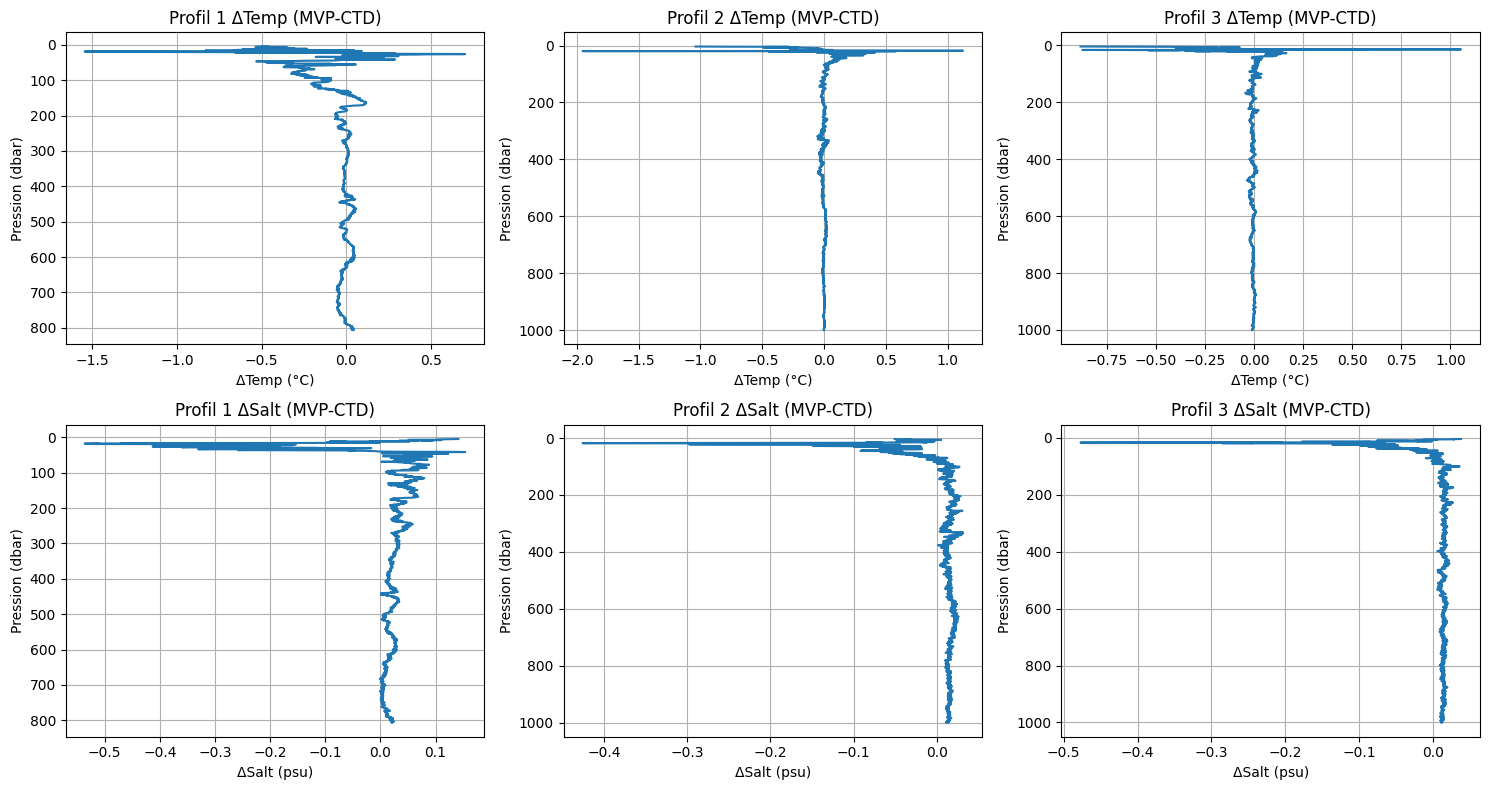

In [53]:
# differences study between MVP down and CTD profiles

# Calcul des différences entre les profils interpolés (MVP - CTD)
diff_temp_down = TEMP_mvp_interp_down - TEMP_ctd_interp
diff_salt_down = SALT_mvp_interp_down - SALT_ctd_interp

# Masquer les NaN pour les statistiques
mask_temp = ~np.isnan(diff_temp_down)
mask_salt = ~np.isnan(diff_salt_down)

# Statistiques température
print("Différences Température (MVP - CTD) sur 3 profils :")
print(f"  Moyenne : {np.nanmean(diff_temp_down):.3f} °C")
print(f"  Médiane : {np.nanmedian(diff_temp_down):.3f} °C")
print(f"  Écart-type : {np.nanstd(diff_temp_down):.3f} °C")
print(f"  Min : {np.nanmin(diff_temp_down):.3f} °C")
print(f"  Max : {np.nanmax(diff_temp_down):.3f} °C\n")

# Statistiques salinité
print("Différences Salinité (MVP - CTD) sur 3 profils :")
print(f"  Moyenne : {np.nanmean(diff_salt_down):.3f} psu")
print(f"  Médiane : {np.nanmedian(diff_salt_down):.3f} psu")
print(f"  Écart-type : {np.nanstd(diff_salt_down):.3f} psu")
print(f"  Min : {np.nanmin(diff_salt_down):.3f} psu")
print(f"  Max : {np.nanmax(diff_salt_down):.3f} psu\n")

# Plots des différences pour chaque profil
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=False)
for k in range(3):
    axs[0, k].plot(diff_temp_down[k], pressure_grid)
    axs[0, k].set_title(f'Profil {k+1} ΔTemp (MVP-CTD)')
    axs[0, k].invert_yaxis()
    axs[0, k].set_xlabel('ΔTemp (°C)')
    axs[0, k].set_ylabel('Pression (dbar)')
    axs[0, k].grid()

    axs[1, k].plot(diff_salt_down[k], pressure_grid)
    axs[1, k].set_title(f'Profil {k+1} ΔSalt (MVP-CTD)')
    axs[1, k].invert_yaxis()
    axs[1, k].set_xlabel('ΔSalt (psu)')
    axs[1, k].set_ylabel('Pression (dbar)')
    axs[1, k].grid()

plt.tight_layout()
plt.show()

Observe the effect of different processes

In [54]:


%matplotlib tk
plt.figure(1)
# plt.plot(TEMP_mvp[0],PRES_mvp[0],label='MVP filtered by MVP software')
# plt.plot(TEMP_mvp_raw[0],PRES_mvp_raw[0],label='MVP raw')
plt.plot(TEMP0[0],PRES0[0],label='MVP filtered waves')
# plt.plot(TEMP_align[0],PRES0[0],label='MVP aligned with lag')
plt.plot(TEMP_final[0],PRES0[0],label='MVP final')
plt.plot(TEMP_ctd[0],PRES_ctd[0],label='CTD')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Temperature, C')   
plt.ylabel('Pressure, dbar')
plt.title('MVP  Temperature profile')
plt.show()

plt.figure(2)
# plt.plot(SALT_mvp[0],PRES_mvp[0],label='MVP  filtered by MVP software')
# plt.plot(SALT_mvp_raw[0],PRES_mvp_raw[0],label='MVP raw')
plt.plot(S0[0],PRES0[0],label='MVP filtered waves')
# plt.plot(SAL_align[0],PRES0[0],label='MVP aligned with lag')
plt.plot(SAL_final[0],PRES0[0],label='MVP final')
plt.plot(SALT_ctd[0],PRES_ctd[0],label='CTD')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Salinity, psu')
plt.ylabel('Pressure, dbar')
plt.title('MVP Salinity profile')
plt.show()


In [55]:
%matplotlib inline

Text(0, 0.5, 'Temperature, C')

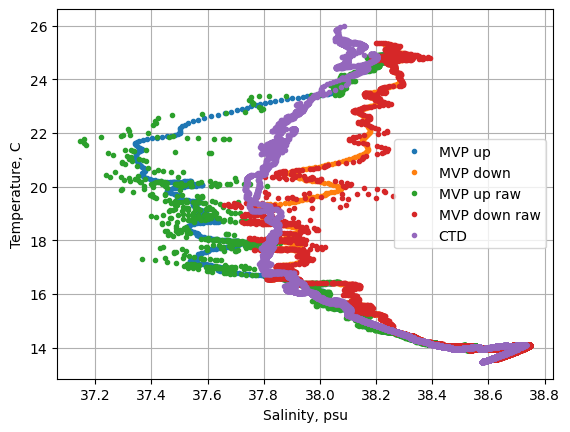

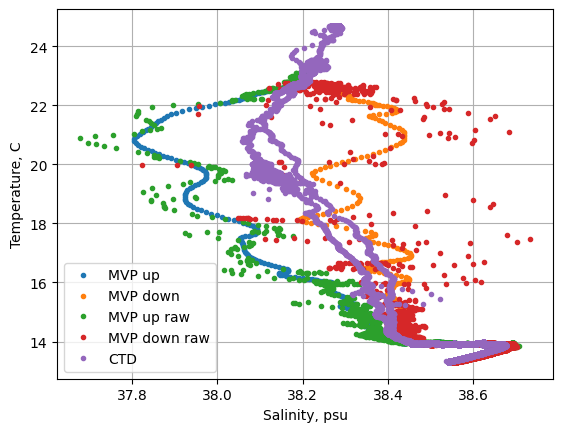

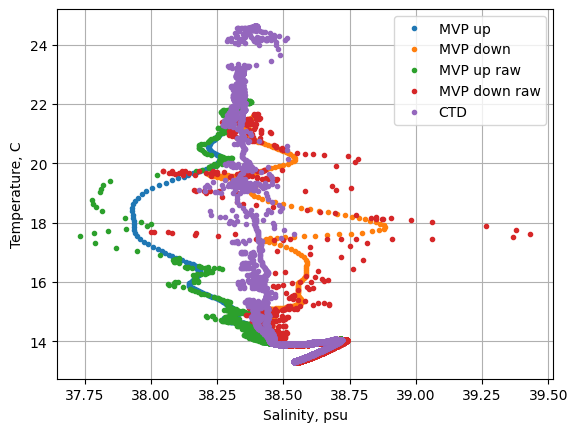

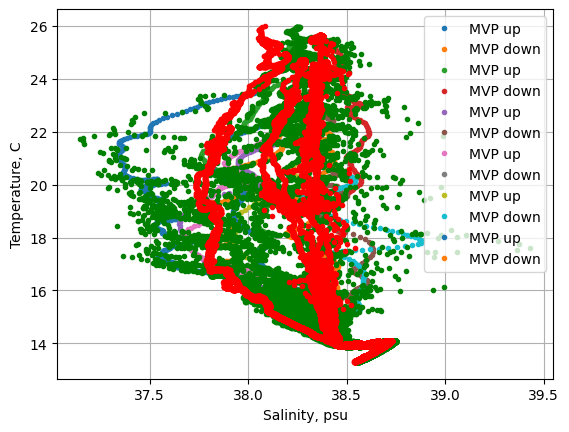

In [56]:
SA = np.linspace(37, 39, 100)  # Absolute Salinity [g/kg]
CT = np.linspace(12, 28, 100)   # Conservative Temperature [°C]
SA_grid, CT_grid = np.meshgrid(SA, CT)

# Calcul de la densité potentielle sigma0 (kg/m³ - 1000)
sigma0 = gsw.sigma0(SA_grid, CT_grid)

# Tracer le fond avec les isopycnes

i = 0
j=0

plt.figure(1)
plt.plot(S0[i],TEMP0[i],label='MVP up',linestyle='', marker='.')
plt.plot(S0[i+1],TEMP0[i+1],label='MVP down',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i],TEMP_mvp_raw[i],label='MVP up raw',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i+1],TEMP_mvp_raw[i+1],label='MVP down raw',linestyle='', marker='.')
plt.plot(SALT_ctd[j],TEMP_ctd[j],label='CTD', linestyle='', marker='.')
plt.legend() 
plt.grid() 
# plt.contour(SA_grid, CT_grid, sigma0, colors='k', linestyles='dotted')
plt.xlabel('Salinity, psu') 
plt.ylabel('Temperature, C')

i = 10
j= 1

plt.figure(2)
plt.plot(S0[i],TEMP0[i],label='MVP up',linestyle='', marker='.')
plt.plot(S0[i+1],TEMP0[i+1],label='MVP down',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i],TEMP_mvp_raw[i],label='MVP up raw',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i+1],TEMP_mvp_raw[i+1],label='MVP down raw',linestyle='', marker='.')
plt.plot(SALT_ctd[j],TEMP_ctd[j],label='CTD', linestyle='', marker='.')
plt.legend()  
plt.grid() 
plt.xlabel('Salinity, psu') 
plt.ylabel('Temperature, C')

i = 8
j= 2

plt.figure(3)
plt.plot(S0[i],TEMP0[i],label='MVP up',linestyle='', marker='.')
plt.plot(S0[i+1],TEMP0[i+1],label='MVP down',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i],TEMP_mvp_raw[i],label='MVP up raw',linestyle='', marker='.')
plt.plot(SALT_mvp_raw[i+1],TEMP_mvp_raw[i+1],label='MVP down raw',linestyle='', marker='.')
plt.plot(SALT_ctd[j],TEMP_ctd[j],label='CTD', linestyle='', marker='.')
plt.legend()  
plt.grid() 
plt.xlabel('Salinity, psu') 
plt.ylabel('Temperature, C')


plt.figure(4)
for i in range(0,len(PRES_mvp),2):
    plt.plot(S0[i],TEMP0[i],label='MVP up',linestyle='', marker='.')
    plt.plot(S0[i+1],TEMP0[i+1],label='MVP down',linestyle='', marker='.')
for i in range(0,len(PRES_mvp_raw),2):
    plt.plot(SALT_mvp_raw[i],TEMP_mvp_raw[i],linestyle='', marker='.',color='green')
    plt.plot(SALT_mvp_raw[i+1],TEMP_mvp_raw[i+1],linestyle='', marker='.',color='green')
for j in range(0,len(PRES_ctd),1):
    plt.plot(SALT_ctd[j],TEMP_ctd[j], linestyle='', marker='.',color='red')
plt.legend()   
plt.grid()
plt.xlabel('Salinity, psu') 
plt.ylabel('Temperature, C')

